In [57]:
import requests
import time
import concurrent.futures
import matplotlib.pyplot as plt

In [58]:

def send_rest(url, method, payload=None):
    try:
        if method == "GET":
            response = requests.get(url)
        elif method == "POST":
            response = requests.post(url, json=payload)
        elif method == "PUT":
            response = requests.put(url, json=payload)
        elif method == "DELETE":
            response = requests.delete(url)
        else:
            raise ValueError(f"Invalid method {method}")
    except:
        print(f"Request failed: {url}")
        return None
    return response


def rest_test(server, request_list, num_requests):
    # print server name
    country = server.split('.')[1]
    print(f"Server: {country}")
    # test every request
    response_times_dict = {}
    for request in request_list: 
        url, method, *args = request
        payload = args[0] if args else None
        # send requests concurrently
        with concurrent.futures.ThreadPoolExecutor() as executor:
            response_times = []
            for i in range(num_requests):
                start_time = time.perf_counter()
                response = send_rest(server + url, method, payload)
                end_time = time.perf_counter()
                response_time = end_time - start_time
                response_times.append(response_time)
            if url in response_times_dict:
                response_times_dict[url].extend(response_times)
            else:
                response_times_dict[url] = response_times
            # total time rounded to 3 decimal places
            total_time = round(sum(response_times), 3)
            
            print(f"URL: {url}, Method: {method}, Total Response Time: {total_time}")

    return response_times_dict

In [59]:
server_list = [
    ('alnike.japaneast.cloudapp.azure.com', '20.210.110.130')
    # ,               
    # ('useast-lennart.eastus2.cloudapp.azure.com', '20.1.139.66'),               
    # ('uswest-thiers.westus3.cloudapp.azure.com', '20.106.100.68'),               
    # ('dapps.westeurope.cloudapp.azure.com', '98.71.185.120')
]

num_requests = 10
rest_port = 8081
soap_port = 8082

rest_request_list = [
    ['/rest/order', 'POST', {'address': '123 Main St', 'meals': ['Portobello', 'Portobello']}],
    ['/rest/meals', 'GET'],
    ['/rest/largest-meal', 'GET'],
    ['/rest/cheapest-meal', 'GET']
]

response_times_dict = {}

this_ip = requests.get('https://api.ipify.org').text

for dns, ip in server_list:
    # if this is the current server, skip
    if ip == this_ip: continue
    
    # test REST
    server_url = f"http://{dns}:{rest_port}"
    response_times = rest_test(server_url, rest_request_list, num_requests)
    for url, times in response_times.items():
        if url not in response_times_dict:
            response_times_dict[url] = {}
        response_times_dict[url][dns] = times
    print('\n')

Server: japaneast
URL: /rest/order, Method: POST, Total Response Time: 5.461
URL: /rest/meals, Method: GET, Total Response Time: 5.149
URL: /rest/largest-meal, Method: GET, Total Response Time: 4.756
URL: /rest/cheapest-meal, Method: GET, Total Response Time: 4.665




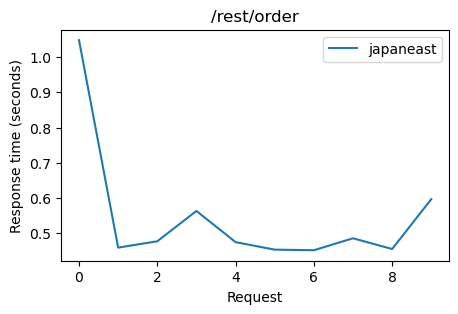

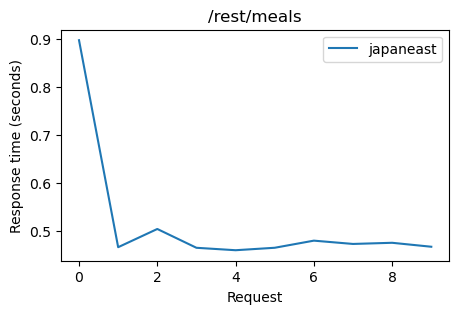

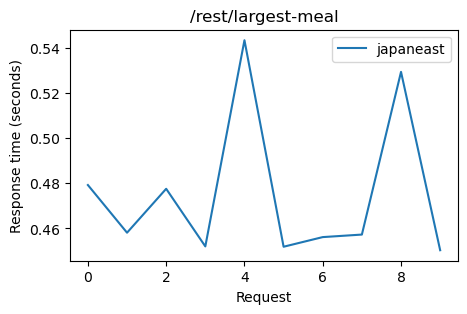

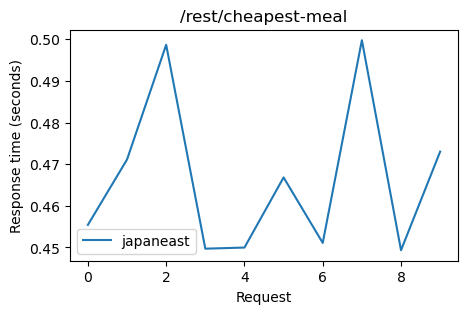

In [60]:
for url, times_dict in response_times_dict.items():
    plt.figure(figsize=(5, 3))
    for dns, response_times in times_dict.items():
        country = dns.split('.')[1]
        plt.plot(response_times, label=country)
    plt.title(url)
    plt.xlabel('Request')
    plt.ylabel('Response time (seconds)')
    plt.legend()
plt.show()


In [61]:
import subprocess

notebook = 'server_test'
result = subprocess.run(['jupyter', 'nbconvert', '--to', 'latex', notebook+'.ipynb'], capture_output=True, text=True)
result = subprocess.run(['pdflatex', '--shell-escape', notebook+'.tex'], capture_output=True, text=True)